In [1]:
from datetime import date
try:
  import yfinance as yf
except:
  !pip install yfinance
  import yfinance as yf
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.1 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drivepath = "/content/drive/MyDrive/WQU/WQU - Deep Learning/DL - Module 3/Candle Data"

Mounted at /content/drive


## DEEP LEARNING FOR FINANCE


MODULE 3 | LESSON 2


---

# **TRANSFER LEARNING FOR CONVOLUTIONAL NEURAL NETWORKS** 

|  |  |
|:---|:---|
|**Reading Time** |  45 minutes |
|**Prior Knowledge** | CNNs, MLPs, Machine learning  |
|**Keywords** | Transfer learning, convolutional networks|


---

## **1. INTRODUCTION**

In previous lessons, we described a series of CNN architectures that have been proven successful in dealing with complex image recognition tasks. Most of the time, these architectures are large-scale models trained from large-scale datasets.

We can leverage these trained architectures in our own classification problems. This technique, labeled **transfer learning**, may solve two issues. First, we may not have many training examples, which may lead to overfitting of complicated models. Second, the accuracy of the trained model with relatively few examples may not meet practical requirements.

Transfer learning  applies the knowledge learned from a *source*
dataset where the network was trained to a *target* dataset. Although the images in our target dataset may be completely different from those contained in the source dataset, the transfered model may be able to extract more general features. This ability may turn out to also be effective for recognizing the objects in our target dataset. Thus, transfer learning may considerably enhance the predicted ability of the model using a pre-trained model with a relatively low computational cost.

Transfer learning involves the following steps:

1. Pre-train a neural network model, i.e., the source model, on a source dataset. We can also obtain the pre-trained parameters directly as obtained from an external source.
2. Create a new neural network model, i.e., the target model. This copies the architecture and the parameters on the source model except the output layer. The parameters contain the knowledge learned from the source dataset, and this knowledge will also be applicable to the target dataset. We do not use the pre-trained output layer because the output layer of the source model is closely related to the labels of the source dataset.
3. Add an output layer to the target model, whose number of outputs is the number of categories in the target dataset. Then, randomly initialize the model parameters of this layer.
4. Train the target model on the target dataset, such as our candlestick charts. The output layer will be trained from scratch, while the parameters of all the other layers are either left untrained and fixed to their pre-trained values or fine-tuned with initial values set at those of the source model and using a very small learning rate.

In this notebook, we are going to use transfer learning to train a CNN to predict stock returns from candlestick charts. Our pre-trained architecture is called "[Xception](https://arxiv.org/abs/1610.02357)." The Xception architecture exploits a special type of convolutional operator called "Separable convolution," which is meant to reduce the computational burden of the model and generalizes the multi-branch blocks that are included in the "Inception" model.

A separable convolution is composed of two steps. First, we apply the usual convolution operator to each input channels using a single kernel with as many dimensions as input channels. However, instead of adding up the results as in a standard convolution, we keep the results separate in different dimensions (that is why this convolution is called "Separable"). 

In the second step, we apply 1x1 convolution to the layer obtained in the previous step, with as many output channels as we desire, using the standard convolution operator. That is, we have, for each output dimension, a 1x1 kernel with as many dimensions as input channels.


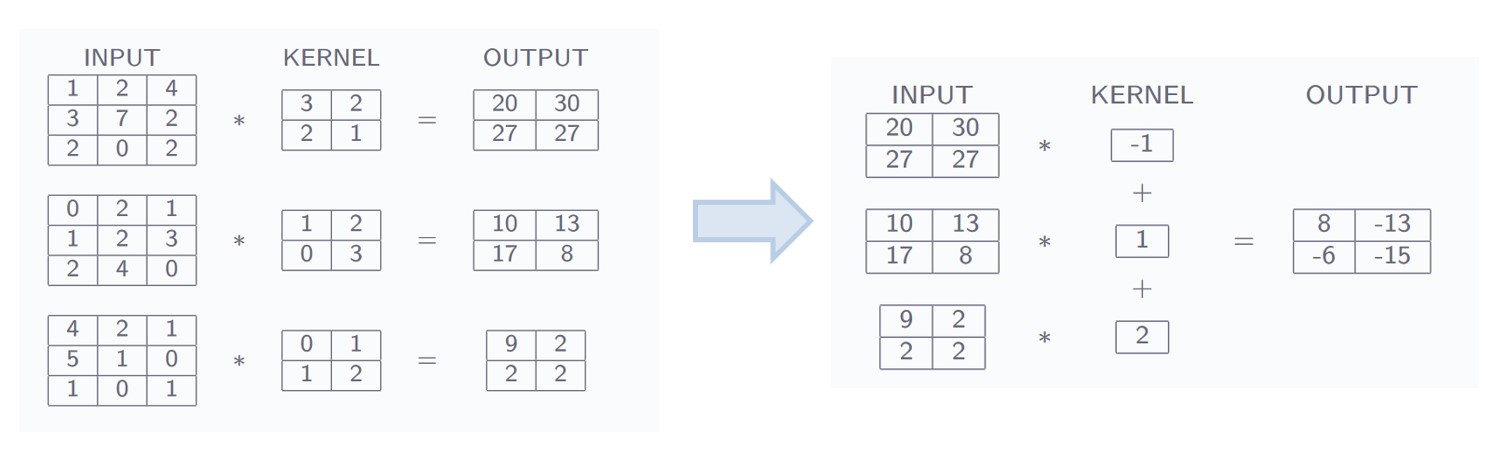

To get some idea of the savings of computational costs, consider the following example. Assume we have an input image with 256x256 pixels and 3 channels. Consider a standard convolutional layer that applies kernels of width equal to 3, with 64 output channels, no padding, and a stride of 1. Thus, the output's height and width will be of 254. In a single kernel window, the convolution implies 9 multiplications. This means that sliding a single kernel through the whole input requires 9x254x254x3 multiplications, or 1,741,932. Repeating this through all the output channels, 64, increases the multiplications to 111,483,648.

Now let's consider the computational requirements of a separable convolution. The first step requires the initial 9x254x254x3 multiplications, and the second step, 1x1 convolutions, involves 254x254x3x64 additional multiplications. In total, the separable convolution makes 14,129,004 multiplications. These are a great deal of mutiplications but a lot less than those performed with a standard convolution.

The separable convolution considerably reduces the number of parameters in a convolution. In the example above, the separable convolution involves 27 weights in the 3x3 kernels and 192 weights in the 1x1 convolutions. In contrast, the standard convolution would require 9x3x64=1,728 trainable parameters. This may damage your network if it is already small. If used properly, separable convolutions may speed up training without damaging the predictive ability.

You can find extended descriptions of separable convolutions in the following [link](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728).

As illustrated below, Xception is a CNN architecture that containes successive layers of multi-branch blocks of convolutions, where the "inside" branches includes separable convolutions. 

[Source of picture](https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/ch3-xception/xception-architectural-design).

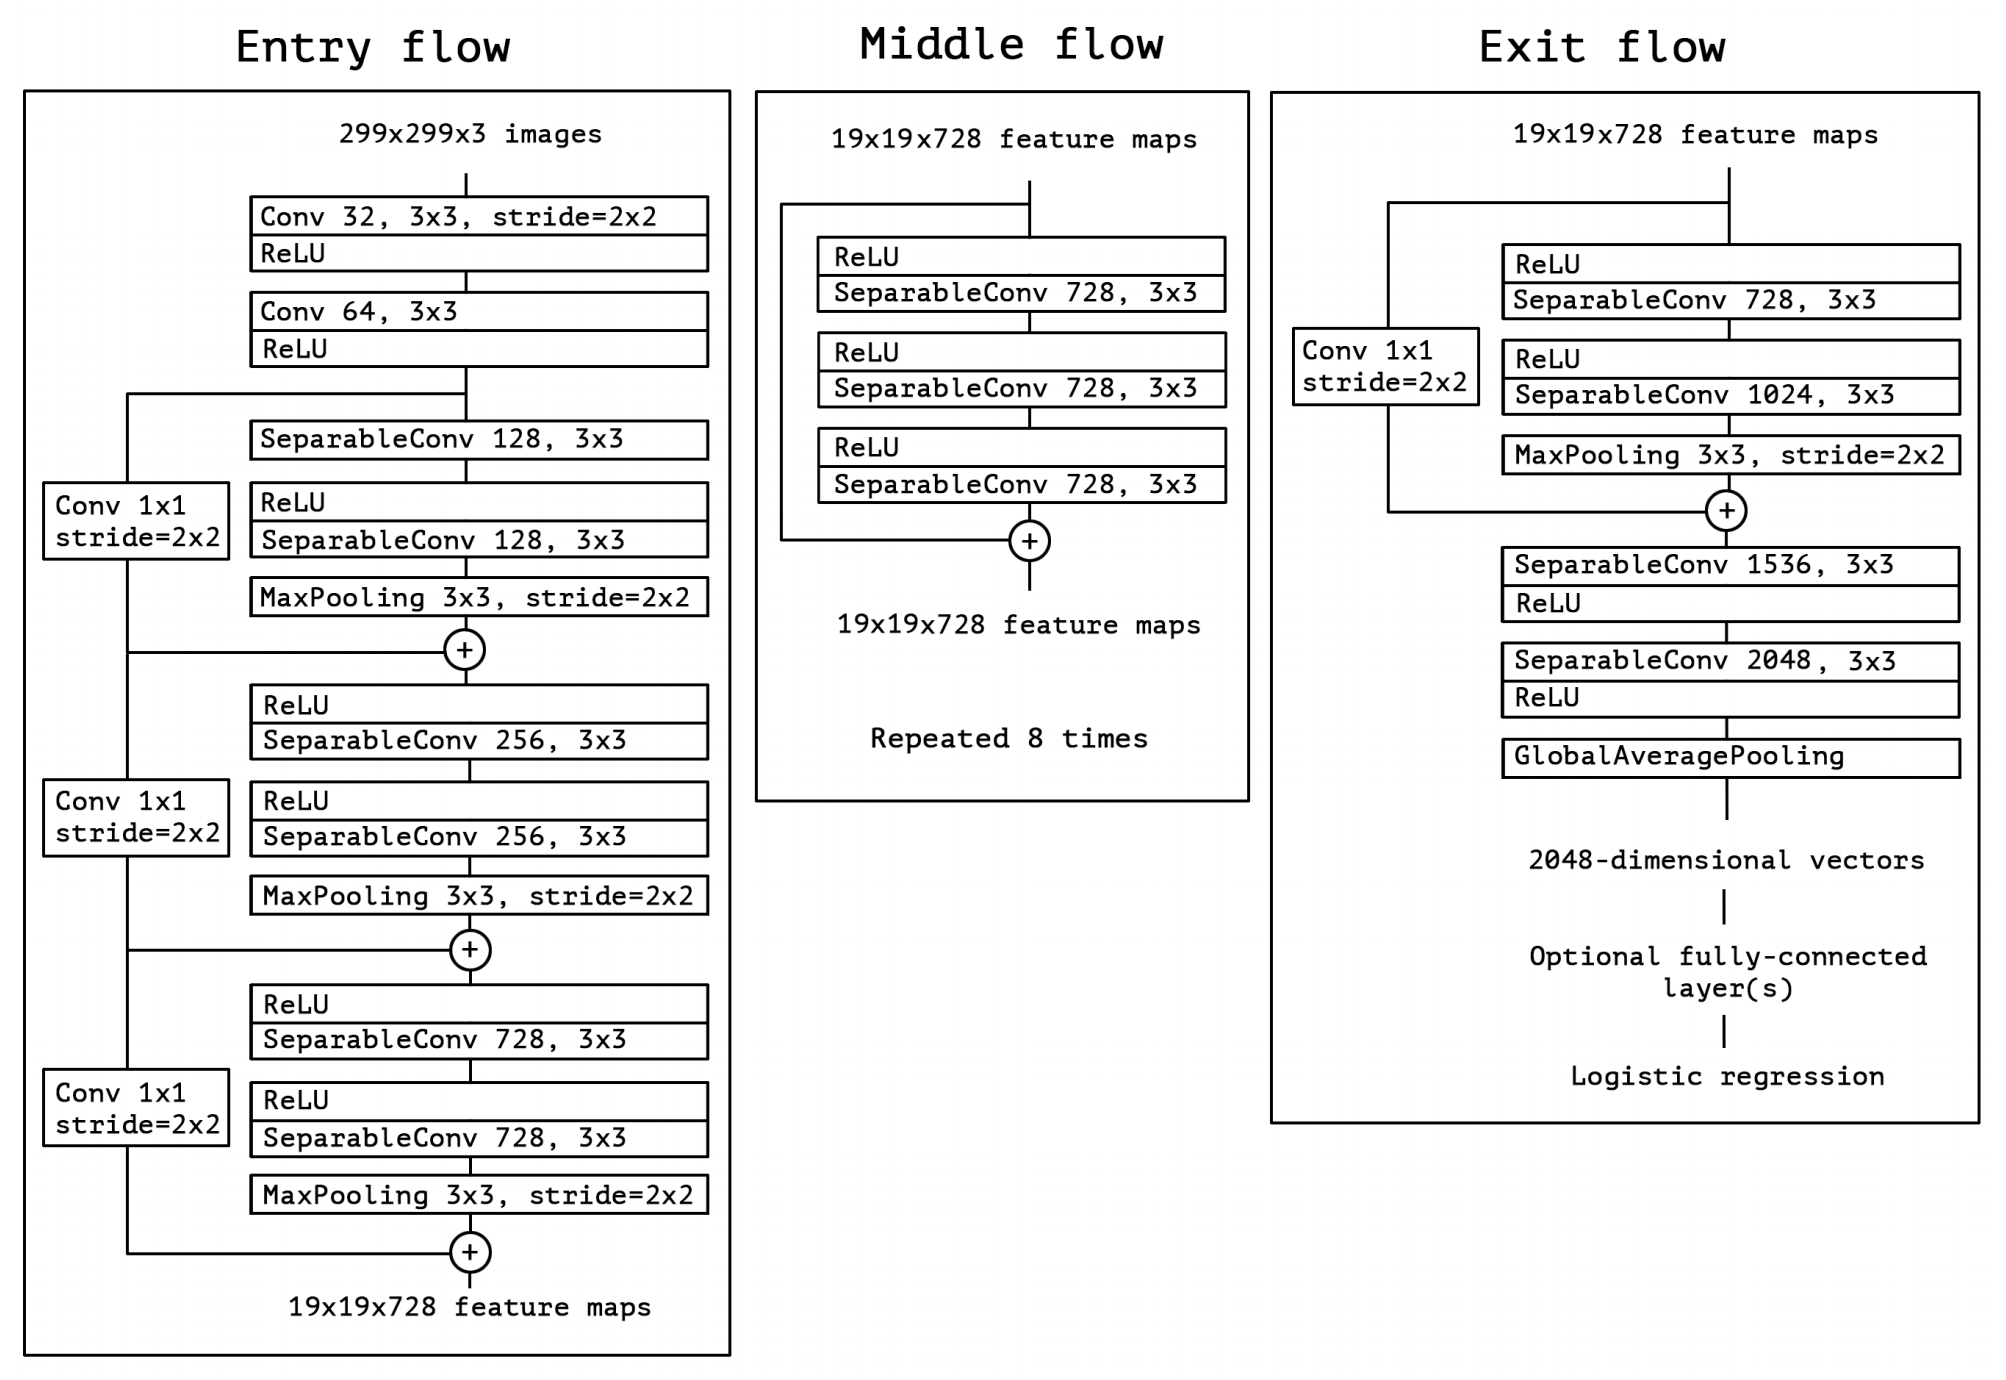



## **2. LOADING THE DATASET**

In [3]:
import tensorflow as tf
path_train = drivepath +'/Train'
path_test = drivepath +'/Test'
# Training set
train = tf.keras.preprocessing.image_dataset_from_directory(path_train, 
                                                     image_size=(250, 250), 
                                                     label_mode='binary')
# Validation set
test = tf.keras.preprocessing.image_dataset_from_directory(path_test, 
                                                     image_size=(250, 250), 
                                                     label_mode='binary')
classes = train.class_names

Found 1280 files belonging to 2 classes.
Found 360 files belonging to 2 classes.


In [4]:
# Transform the input images to numpy arrays of dimension 250x250x3
import numpy as np
X_train, y_train = np.array([]).reshape(-1, 250, 250, 3), np.array([]).reshape(-1, 1)
for X, y in train:
    X_train = np.concatenate([X_train, X])
    y_train = np.concatenate([y_train, y])

## **3. ARCHITECTURE**

As described above, we are going to train a CNN using transfer learning. We load the pre-trained Xception network. We refer to the documentation available [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception), where you can see the available options.

The pretrained Xception architecture represents the main body of the network. We just need to determine the shape of the input tensor (250x250x3) and then add the "top" part of the network that represents our trainable part of the model. We include a flattening layer and a fully connected layer with 512 hidden units and ReLU activation, which then leads to a final output layer with a sigmoid activation.

In [5]:
base = tf.keras.applications.Xception(
    input_tensor=tf.keras.layers.Input(shape=(250,250,3)),
    weights='imagenet', 
    include_top=False,
    pooling = 'avg'
)
flatten = tf.keras.layers.Flatten()(base.output)
fcdense = tf.keras.layers.Dense(512, activation='relu')(flatten)
sigmoid = tf.keras.layers.Dense(1, activation='sigmoid')(fcdense)
model = tf.keras.models.Model(inputs=base.input, outputs=sigmoid)
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

83683744/83683744 [==============================] - 4s 0us/step


Let's see the structure of the model, which is gigantic.

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 124, 124, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

## **3. TRAINING AND PERFORMANCE**

Now, we train the model for 20 epochs, giving some additional weight to the class that is less frequent in the dataset. We will choose the model that achieves the highest accuracy in the validation set.

In [7]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='auto') 
from sklearn.utils import class_weight
class_weight = {0: 1/(1-np.mean(y_train)), 1: 1.0}
print(class_weight)
model.fit(train, epochs=20, validation_data=test, verbose=1, callbacks=[checkpoint], class_weight = class_weight)

{0: 1.5274463007159904, 1: 1.0}
Epoch 1/20
40/40 [==============================] - 200s 4s/step - loss: 0.8583 - accuracy: 0.6461 - val_loss: 0.6988 - val_accuracy: 0.5556
Epoch 2/20
40/40 [==============================] - 29s 701ms/step - loss: 0.7289 - accuracy: 0.6547 - val_loss: 0.7165 - val_accuracy: 0.5556
Epoch 3/20
40/40 [==============================] - 28s 680ms/step - loss: 0.6243 - accuracy: 0.6609 - val_loss: 2.4851 - val_accuracy: 0.5556
Epoch 4/20
40/40 [==============================] - 28s 672ms/step - loss: 0.5227 - accuracy: 0.7641 - val_loss: 3.7885 - val_accuracy: 0.5306
Epoch 5/20
40/40 [==============================] - 32s 770ms/step - loss: 0.4211 - accuracy: 0.8344 - val_loss: 4.8579 - val_accuracy: 0.5667
Epoch 6/20
40/40 [==============================] - 29s 696ms/step - loss: 0.2991 - accuracy: 0.8891 - val_loss: 3.9779 - val_accuracy: 0.5722
Epoch 7/20
40/40 [==============================] - 28s 684ms/step - loss: 0.2284 - accuracy: 0.9258 - val_loss:

Below we present the performance metrics of the trained model. The performance of the model depends on the random initialization of the trainable parameters. However, if you train the model several times, you will notice that it tends to perform better than the basic CNN architecture that we trained at the end of Module 2, achieving some gains in accuracy and other metrics. Notice, however, that the model still seems to predict too often a "down" move. Bear in mind, that the number of examples used in this application is quite small relative to the datasets that we usually confront in image recognition applications. You can see that the model overfits the training set, which may be solved by adding more examples in training that allows the model to improve its generalization capacity.

12/12 [==============================] - 4s 159ms/step - loss: 3.8272 - accuracy: 0.5944
Accuracy: 59.44%
12/12 [==============================] - 3s 171ms/step
              precision    recall  f1-score   support

         0.0       0.58      0.94      0.72       200
         1.0       0.69      0.16      0.26       160

    accuracy                           0.59       360
   macro avg       0.64      0.55      0.49       360
weighted avg       0.63      0.59      0.51       360



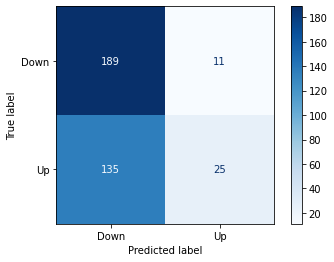

In [8]:
from sklearn import metrics 
model = tf.keras.models.load_model('model.h5')
acc = model.evaluate(test)
print("Accuracy: {:.2f}%".format(acc[1] * 100))
X_test, y_test = np.array([]).reshape(-1, 250, 250, 3), np.array([]).reshape(-1, 1)
for X, y in test:
    X_test = np.concatenate([X_test, X])
    y_test = np.concatenate([y_test, y])
y_prob = model.predict(X_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm.plot(values_format='', cmap='Blues')
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## **4. CONCLUSION**

In this lesson, we have described how transfer learning may enhance the performance of our CNNs while reducing the computational costs. We have also introduced the concept of "separable convolution" that is used in the Xception architecture.